# GPU-accelerated Scalable GP Regression in 1D (w/ KISS-GP)

## Introduction

For 1D functions, SKI (or KISS-GP) is a great way to scale a GP up to very large datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

SKI is asymptotically very fast (nearly linear), very precise (error decays cubically), and easy to use in GPyTorch!
As you will see in this tutorial, it's really easy to apply SKI to an existing model. All you have to do is wrap your kernel module with a `GridInterpolationKernel`.

This is the same as [the standard KISSGP 1D notebook](./KISSGP_Regression_1D.ipynb), but where everything is super-charged with CUDA. SKI is especially fast on the GPU.

The only thing required for GPU acceleration: `train_x.cuda()`, `train_y.cuda()`, and `model.cuda()`.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [2]:
train_x = torch.linspace(0, 1, 1000).cuda()
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()).cuda() * 0.2)

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using the same number of grid points as training points (a ratio of 1). Performance can be sensitive to this parameter (the number of grid points), so you may want to adjust it to your problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood).cuda()

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    training_iterations = 30
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
%time train()

Iter 1/30 - Loss: 1.137
Iter 2/30 - Loss: 1.109
Iter 3/30 - Loss: 1.080
Iter 4/30 - Loss: 1.052
Iter 5/30 - Loss: 1.023
Iter 6/30 - Loss: 0.994
Iter 7/30 - Loss: 0.963
Iter 8/30 - Loss: 0.933
Iter 9/30 - Loss: 0.900
Iter 10/30 - Loss: 0.860
Iter 11/30 - Loss: 0.804
Iter 12/30 - Loss: 0.721
Iter 13/30 - Loss: 0.612
Iter 14/30 - Loss: 0.492
Iter 15/30 - Loss: 0.382
Iter 16/30 - Loss: 0.296
Iter 17/30 - Loss: 0.230
Iter 18/30 - Loss: 0.172
Iter 19/30 - Loss: 0.122
Iter 20/30 - Loss: 0.074
Iter 21/30 - Loss: 0.027
Iter 22/30 - Loss: -0.021
Iter 23/30 - Loss: -0.063
Iter 24/30 - Loss: -0.108
Iter 25/30 - Loss: -0.145
Iter 26/30 - Loss: -0.187
Iter 27/30 - Loss: -0.224
Iter 28/30 - Loss: -0.263
Iter 29/30 - Loss: -0.300
Iter 30/30 - Loss: -0.331
CPU times: user 2.43 s, sys: 100 ms, total: 2.53 s
Wall time: 2.52 s


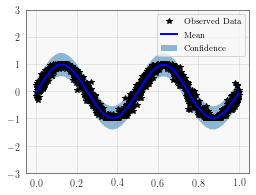

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).cuda()
    prediction = likelihood(model(test_x))
    mean = prediction.mean
    # Get lower and upper predictive bounds
    lower, upper = prediction.confidence_region()

# Plot the training data as black stars
ax.plot(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), mean.detach().cpu().numpy(), 'b')
# Plot confidence bounds as lightly shaded region
ax.fill_between(test_x.detach().cpu().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

None